In [1]:
import torch
import numpy as np
from models import WorldModel
import matplotlib.pyplot as plt
import yaml
from utils import AttrDict

In [2]:
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_min=-float('inf'), integrator_max=float('inf')):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_min = integrator_min
        self.integrator_max = integrator_max

    def update(self, error):
        # Update integral term with clamping to avoid windup
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, self.integrator_min, self.integrator_max)
        # Compute derivative term
        derivative = (error - self.prev_error) / self.dt
        # Compute PID output
        output = self.kp * error + self.ki * self.integrator + self.kd * derivative
        self.prev_error = error
        return output

In [3]:
# Load the world model
with open("/home/eashan/workspace/DreamingFalconROS/config.yaml", 'r') as file:
    config_dict = yaml.safe_load(file)

config = AttrDict.from_dict(config_dict)
world_model = WorldModel(config, torch.device(config.device)).to(config.device)
checkpoint = torch.load("/home/eashan/workspace/DreamingFalconROS/models/run_x/model.pt")
world_model.load_state_dict(checkpoint["state_dict"])
world_model.eval()  # Set to evaluation mode

# Simulation parameters
dt = 0.05        # time step in seconds
T = 50.0         # total simulation time in seconds
num_steps = int(T / dt)

# Initialize the state vector
# Assuming: [x, y, z, vx, vy, vz, roll, pitch, yaw, roll_rate, pitch_rate, yaw_rate]
state = torch.zeros(12, dtype=torch.float32)
# You may initialize altitude, velocities, etc., as needed:
state[2] = -10.0  # Altitude
state[3] = 0.0  # Initial vx

# Initialize PID controllers for each axis and loop
# Velocity control (outer loop)
pid_x_vel = PID(kp=1.8, ki=0.4, kd=0.2, dt=dt)  # X velocity
pid_y_vel = PID(kp=1.8, ki=0.4, kd=0.2, dt=dt)  # Y velocity
pid_z_pos = PID(kp=1.0, ki=0.0, kd=0.0, dt=dt)   # Z position (altitude)
pid_z_vel = PID(kp=4.0, ki=2.0, kd=0.0, dt=dt)  # Z velocity (altitude rate)


# Attitude control (middle loop)
pid_roll = PID(kp=6.5, ki=0.0, kd=0.0, dt=dt)   # Roll angle
pid_pitch = PID(kp=6.5, ki=0.0, kd=0.0, dt=dt)  # Pitch angle
pid_yaw = PID(kp=6.5, ki=0.0, kd=0.0, dt=dt)   # Yaw angle (different gains)

# Rate control (inner loop)
pid_roll_rate = PID(kp=0.15, ki=0.2, kd=0.003, dt=dt)   # Roll rate
pid_pitch_rate = PID(kp=0.15, ki=0.2, kd=0.003, dt=dt)  # Pitch rate
pid_yaw_rate = PID(kp=0.2, ki=0.1, kd=0.0, dt=dt)   # Yaw rate (different gains)

# Logging variables
time_log = []
# Velocity
x_vel_log, y_vel_log = [], []
# Z velocity
z_vel_log = []
target_z_vel_log = []
# Position
x_pos_log, y_pos_log, z_pos_log = [], [], []
target_x_vel_log, target_y_vel_log = [], []
# Attitude
roll_log, pitch_log, yaw_log = [], [], []
desired_roll_log, desired_pitch_log, desired_yaw_log = [], [], []
# Rate
roll_rate_log, pitch_rate_log, yaw_rate_log = [], [], []
desired_roll_rate_log, desired_pitch_rate_log, desired_yaw_rate_log = [], [], []
target_z_pos_log = []

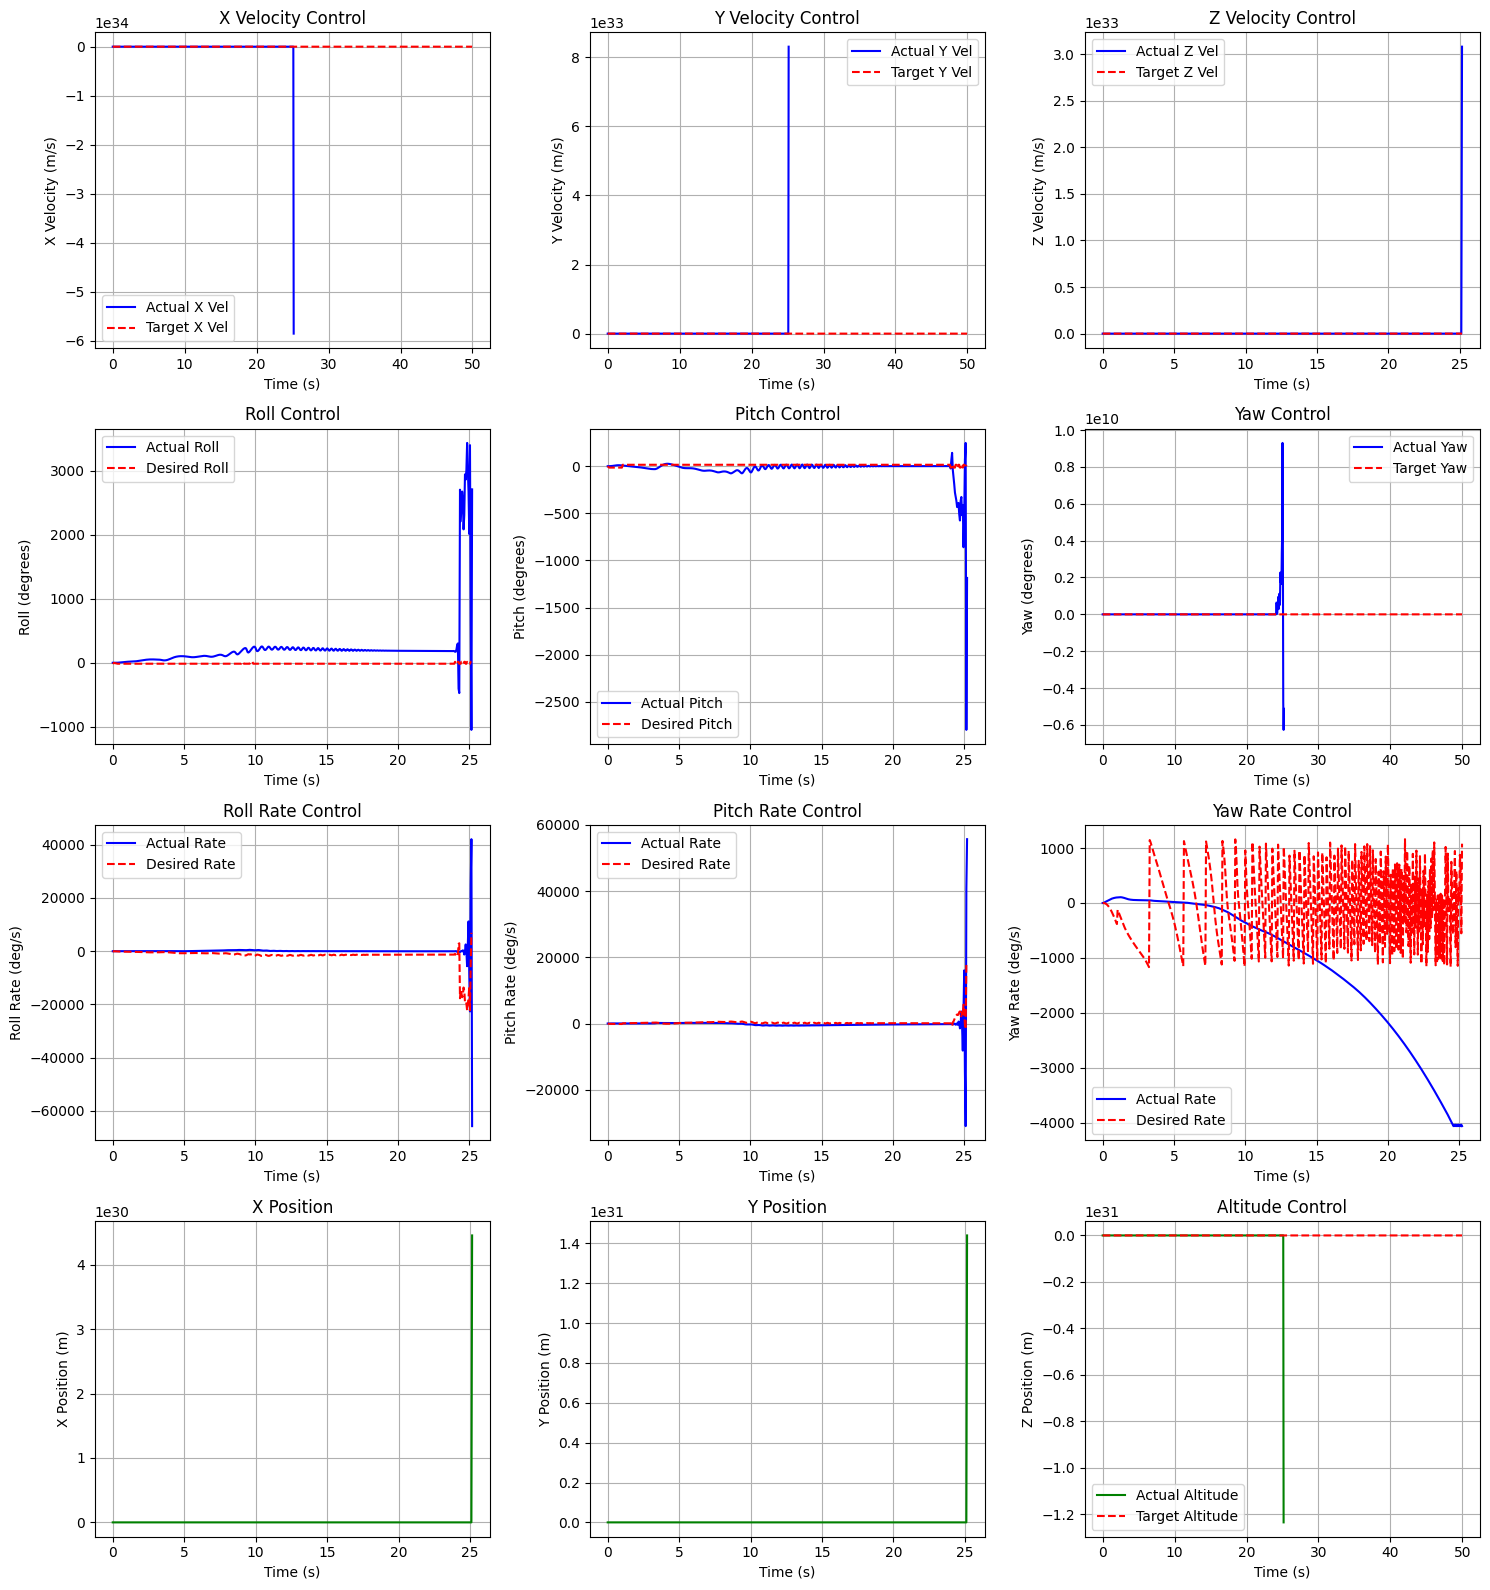

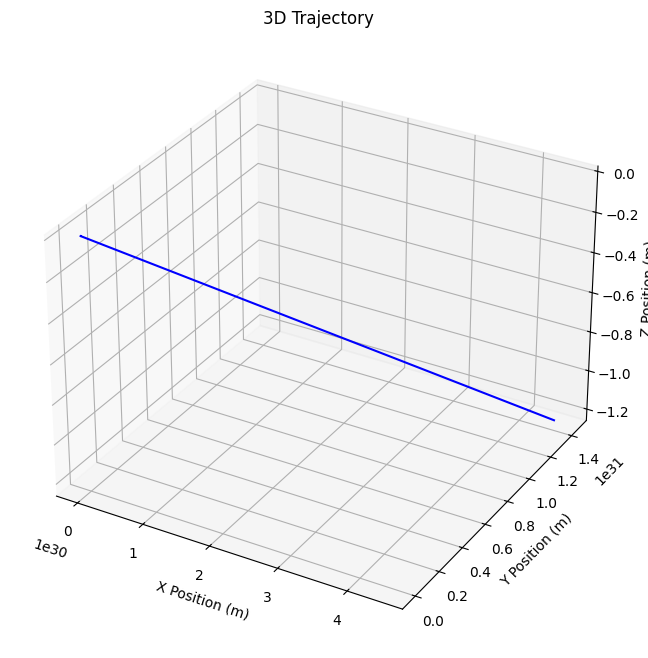

In [8]:
# Simulation loop
for step in range(num_steps):
    t = step * dt
    
    # Define target velocities and positions
    target_x_velocity = 1.0 if t > 1.0 else 0.0  # X velocity (forward)
    target_y_velocity = 0.5 if t > 1.0 else 0.0  # Y velocity (lateral)
    target_yaw = np.radians(45) if t > 1.0 else 0.0  # Target heading
    target_altitude = -10.0  # Initial altitude
    if t > 25.0:
        target_altitude = -8.0  # Change altitude at t=25s
    
    # Extract current state
    current_x_vel = state[3].item()  # vx
    current_y_vel = state[4].item()  # vy
    current_z_vel = state[5].item()  # vz
    current_roll = state[6].item()   # roll
    current_pitch = state[7].item()  # pitch
    current_yaw = state[8].item()    # yaw
    current_roll_rate = state[9].item()   # roll rate
    current_pitch_rate = state[10].item() # pitch rate  
    current_yaw_rate = state[11].item()   # yaw rate
    current_x_pos = state[0].item()  # x position
    current_y_pos = state[1].item()  # y position  
    current_z_pos = state[2].item()  # z position (altitude)
    
    # ---- Z-axis (Altitude) Control Loop ----
    # Position error to velocity command
    z_pos_error = target_altitude - current_z_pos
    target_z_velocity = pid_z_pos.update(z_pos_error)
    target_z_velocity = np.clip(target_z_velocity, -1.0, 1.0)  # Limit vertical velocity
    
    # Velocity error to throttle command
    z_vel_error = target_z_velocity - current_z_vel
    throttle = pid_z_vel.update(z_vel_error)
    throttle = np.clip(throttle, 0.3, 0.9)  # Safe throttle range
    
    # ---- Outer Loop: Velocity Control ----
    # X velocity -> pitch control
    x_vel_error = target_x_velocity - current_x_vel
    desired_pitch = pid_x_vel.update(x_vel_error)
    desired_pitch = np.clip(desired_pitch, np.radians(-15), np.radians(15))
    
    # Y velocity -> roll control
    y_vel_error = target_y_velocity - current_y_vel
    desired_roll = -pid_y_vel.update(y_vel_error)  # Negative because +roll causes -y velocity
    desired_roll = np.clip(desired_roll, np.radians(-15), np.radians(15))
    
    # ---- Middle Loop: Attitude Control ----
    # Roll control
    roll_error = desired_roll - current_roll
    desired_roll_rate = pid_roll.update(roll_error)
    
    # Pitch control
    pitch_error = desired_pitch - current_pitch
    desired_pitch_rate = pid_pitch.update(pitch_error)
    
    # Yaw control (separate gains)
    yaw_error = target_yaw - current_yaw
    # Normalize angle to -pi to pi
    yaw_error = ((yaw_error + np.pi) % (2 * np.pi)) - np.pi
    desired_yaw_rate = pid_yaw.update(yaw_error)
    
    # ---- Inner Loop: Rate Control ----
    # Roll rate
    roll_rate_error = desired_roll_rate - current_roll_rate
    roll_rate_command = pid_roll_rate.update(roll_rate_error)
    
    # Pitch rate
    pitch_rate_error = desired_pitch_rate - current_pitch_rate
    pitch_rate_command = pid_pitch_rate.update(pitch_rate_error)
    
    # Yaw rate
    yaw_rate_error = desired_yaw_rate - current_yaw_rate
    yaw_rate_command = pid_yaw_rate.update(yaw_rate_error)
    
    # ---- Actuator Mixing ----
    # For a quadcopter in X configuration:
    # Use throttle from Z-axis PID instead of fixed base_throttle
    actuator_commands = torch.tensor([0.1,0.1,0.1,0.1], dtype=torch.float32)
        # throttle - pitch_rate_command - roll_rate_command + yaw_rate_command,  # Motor 0 (front left)
        # throttle - pitch_rate_command + roll_rate_command - yaw_rate_command,  # Motor 1 (front right)
        # throttle + pitch_rate_command - roll_rate_command - yaw_rate_command,  # Motor 2 (rear left)
        # throttle + pitch_rate_command + roll_rate_command + yaw_rate_command   # Motor 3 (rear right)
    # ], dtype=torch.float32)
    
    # Clip actuator commands to valid range [0, 1]
    actuator_commands = torch.clamp(actuator_commands, 0.0, 1.0)
    
    # ---- World Model Prediction ----
    with torch.no_grad():
        state = world_model.predict(torch.tensor([dt], dtype=torch.float32).unsqueeze(0), 
                                  state.unsqueeze(0), 
                                  actuator_commands.unsqueeze(0)).squeeze(0)
    
    # Log data
    time_log.append(t)
    # Velocity
    x_vel_log.append(current_x_vel)
    y_vel_log.append(current_y_vel)
    target_x_vel_log.append(target_x_velocity)
    target_y_vel_log.append(target_y_velocity)
    z_vel_log.append(current_z_vel)
    target_z_vel_log.append(target_z_velocity)
    # Position
    x_pos_log.append(current_x_pos)
    y_pos_log.append(current_y_pos)
    z_pos_log.append(current_z_pos)
    target_z_pos_log.append(target_altitude)  # Add this line to log target altitude
    # Attitude
    roll_log.append(current_roll)
    pitch_log.append(current_pitch)
    yaw_log.append(current_yaw)
    desired_roll_log.append(desired_roll)
    desired_pitch_log.append(desired_pitch)
    desired_yaw_log.append(target_yaw)
    # Rate
    roll_rate_log.append(current_roll_rate)
    pitch_rate_log.append(current_pitch_rate)
    yaw_rate_log.append(current_yaw_rate)
    desired_roll_rate_log.append(desired_roll_rate)
    desired_pitch_rate_log.append(desired_pitch_rate)
    desired_yaw_rate_log.append(desired_yaw_rate)

# Plotting results with separate plots for each axis
import matplotlib.pyplot as plt

# Create figure with 4x3 grid for all controllers
plt.figure(figsize=(15, 16))

# --- Row 1: Velocity plots ---
# X Velocity
plt.subplot(4, 3, 1)
plt.plot(time_log, x_vel_log, 'b-', label='Actual X Vel')
plt.plot(time_log, target_x_vel_log, 'r--', label='Target X Vel')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (m/s)')
plt.title('X Velocity Control')
plt.grid(True)
plt.legend()

# Y Velocity 
plt.subplot(4, 3, 2)
plt.plot(time_log, y_vel_log, 'b-', label='Actual Y Vel')
plt.plot(time_log, target_y_vel_log, 'r--', label='Target Y Vel')
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')
plt.title('Y Velocity Control')
plt.grid(True)
plt.legend()

# Z Velocity
plt.subplot(4, 3, 3)
plt.plot(time_log, z_vel_log, 'b-', label='Actual Z Vel')
plt.plot(time_log, target_z_vel_log, 'r--', label='Target Z Vel')
plt.xlabel('Time (s)')
plt.ylabel('Z Velocity (m/s)')
plt.title('Z Velocity Control')
plt.grid(True)
plt.legend()

# --- Row 2: Attitude plots ---
# Roll Attitude
plt.subplot(4, 3, 4)
plt.plot(time_log, [np.degrees(r) for r in roll_log], 'b-', label='Actual Roll')
plt.plot(time_log, [np.degrees(r) for r in desired_roll_log], 'r--', label='Desired Roll')
plt.xlabel('Time (s)')
plt.ylabel('Roll (degrees)')
plt.title('Roll Control')
plt.grid(True)
plt.legend()

# Pitch Attitude
plt.subplot(4, 3, 5)
plt.plot(time_log, [np.degrees(p) for p in pitch_log], 'b-', label='Actual Pitch')
plt.plot(time_log, [np.degrees(p) for p in desired_pitch_log], 'r--', label='Desired Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (degrees)')
plt.title('Pitch Control')
plt.grid(True)
plt.legend()

# Yaw Attitude
plt.subplot(4, 3, 6)
plt.plot(time_log, [np.degrees(y) for y in yaw_log], 'b-', label='Actual Yaw')
plt.plot(time_log, [np.degrees(y) for y in desired_yaw_log], 'r--', label='Target Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.title('Yaw Control')
plt.grid(True)
plt.legend()

# --- Row 3: Rate plots ---
# Roll Rate
plt.subplot(4, 3, 7)
plt.plot(time_log, [np.degrees(r) for r in roll_rate_log], 'b-', label='Actual Rate')
plt.plot(time_log, [np.degrees(r) for r in desired_roll_rate_log], 'r--', label='Desired Rate')
plt.xlabel('Time (s)')
plt.ylabel('Roll Rate (deg/s)')
plt.title('Roll Rate Control')
plt.grid(True)
plt.legend()

# Pitch Rate
plt.subplot(4, 3, 8)
plt.plot(time_log, [np.degrees(r) for r in pitch_rate_log], 'b-', label='Actual Rate')
plt.plot(time_log, [np.degrees(r) for r in desired_pitch_rate_log], 'r--', label='Desired Rate')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Rate (deg/s)')
plt.title('Pitch Rate Control')
plt.grid(True)
plt.legend()

# Yaw Rate
plt.subplot(4, 3, 9)
plt.plot(time_log, [np.degrees(r) for r in yaw_rate_log], 'b-', label='Actual Rate')
plt.plot(time_log, [np.degrees(r) for r in desired_yaw_rate_log], 'r--', label='Desired Rate')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (deg/s)')
plt.title('Yaw Rate Control')
plt.grid(True)
plt.legend()

# --- Row 4: Position plots ---
# X Position
plt.subplot(4, 3, 10)
plt.plot(time_log, x_pos_log, 'g-')
plt.xlabel('Time (s)')
plt.ylabel('X Position (m)')
plt.title('X Position')
plt.grid(True)

# Y Position
plt.subplot(4, 3, 11)
plt.plot(time_log, y_pos_log, 'g-')
plt.xlabel('Time (s)')
plt.ylabel('Y Position (m)')
plt.title('Y Position')
plt.grid(True)

# Z Position (altitude)
plt.subplot(4, 3, 12)
plt.plot(time_log, z_pos_log, 'g-', label='Actual Altitude')
plt.plot(time_log, target_z_pos_log, 'r--', label='Target Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Z Position (m)')
plt.title('Altitude Control')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Also add a 3D trajectory plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_pos_log, y_pos_log, z_pos_log, 'b-')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('3D Trajectory')
plt.show()